In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [13]:
from IPython.display import Image, Video

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context("poster")
%matplotlib inline

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-10-17T01:41:28-04:00

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-1093-oem
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit


In [14]:
%%bash
echo "Current branch"
git branch

Current branch
  explore_appr_retr
* master
  refactor_appr_retr


# Brain State Predictions

- Functional magnetic resonance imaging (fMRI) data was collected from 61 study participants.
- Participants viewed a visual stimuli on projection screen via a mirror mounted to the scanner's head coil. 

## Visual Stimuli
- Two circles moved around on the screen randomly. 
- When circles collided, an unpleasant mild electric shock was delivered to the index and middle fingers of the participant's left hand.
- Shock delivery was meant to induce neural response associated with threat anticipation and relief when the participant saw the circles approaching and retreating, respectively.

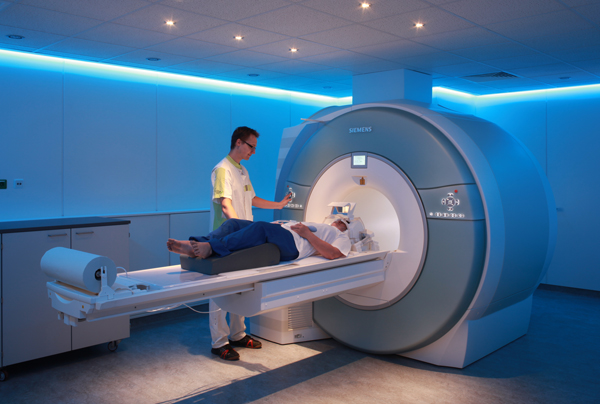 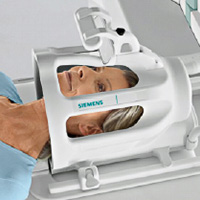
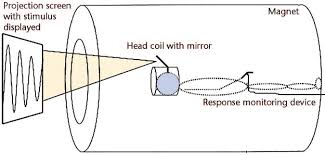

In [15]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src="support/videos/emoprox2Exp.mp4" type="video/mp4">
</video></div>

<div>
<img src="support/images/scanner.jpg" width="300"/>
</div>

<img src="support/images/head_coil.jpg" /> <img src="support/images/projection_screen.jpeg" width="400"/>

In [ ]:
with open("data/processed/00a-ROI316_withShiftedSegments.pkl","rb") as f:
    dataset=pickle.load(f)

Consider the following raw segment from a voxel for a near-miss event. First 7 TRs correspond to __approach__ (red shade) and later 7 to __retreat__ (green shade). 

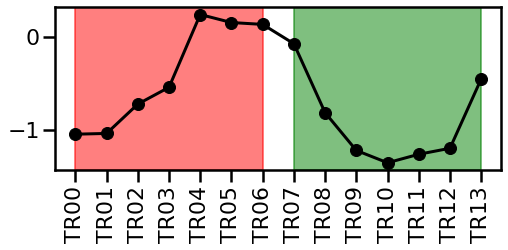

In [5]:
insula = np.squeeze(dataset['CON054']['data'][:,[108],0:36:6])
plt.figure(figsize=(8,3))
plt.plot(np.arange(14)*1.25,insula[:,0],c='k',marker='o')
plt.axvspan(0,7.5,color='red',alpha=0.5)
plt.axvspan(8.75,16.25,color='green',alpha=0.5)
_=plt.xticks(np.arange(14)*1.25, labels=['TR{:02d}'.format(tr) for tr in np.arange(14)],rotation=90)

In LSTM, the approach and retreat segments are fed as separate training examples along with proper labels as follows:
    
    
    training example 1: [TR00, TR01, TR02, TR03, TR04, TR05, TR06] -> "approach"  
    training example 2: [TR07, TR08, TR09, TR10, TR11, TR12, TR13] -> "retreat"  


Problem with this kind of training data is that the model is able to accurately distinguish between the two classes only when it encounters a "pure" segment, i.e., whose all TRs are either in __approach__ (or __retreat__) mode, because that is how the model is trained. It fails to accurately predict those TRs where approach turns into retreat or vice versa. 

To make the model more sensitive to approach-to-retreat (or vice versa) transitions, both classes of the model, besides being trained on pure segments, should also be trained on "transition"  segments, i.e., segments in which transition takes place. The transition segments are given the label of the class they transition into.

#### __Transition Segments__  
Consider just __approach__. The curve from TR00-06 in the above plot represents a pure approach segment. This segment can be shifted one step back in time such that its first TR (TR00 - 1) is where the retreat-to-approach transition occurs. However, it is not known for sure that TR00 - 1 is the transition TR. Maybe TR00 - 2 is the transition TR. To ensure that transition segments are adequately represented in the training data, the pure approach segment (of length 7) is shifted five steps back in time, and each step forms a new training example. For example, the single ``training example 1`` shown above expands into 6 training examples as follows:


                        <-------------------------------  Time  ------------------------------------->
    training example 1:                                     [TR00, TR01, TR02, TR03, TR04, TR05, TR06] -> "approach"  
                                                     [-TR01, TR00, TR01, TR02, TR03, TR04, TR05]       -> "approach"
                                              [-TR02, -TR01, TR00, TR01, TR02, TR03, TR04]             -> "approach"
                                       [-TR03, -TR02, -TR01, TR00, TR01, TR02, TR03]                   -> "approach"
                                [-TR04, -TR03, -TR02, -TR01, TR00, TR01, TR02]                         -> "approach"
                         [-TR05, -TR04, -TR03, -TR02, -TR01, TR00, TR01]                               -> "approach"
 
Plot below shows the pure approach segment (same as the one plotted above), along with its 5 shifted segments that capture transition from retreat to approach. 

In [6]:
approach, retreat = [], []
for i in range(insula.shape[1]):
    if i == 0:
        name = "pure"
    else:
        name = "pure - %i TRs" %(i)
    approach.append(pd.Series(insula[:7,i],index=np.arange(7)-i,name=name))
    retreat.append(pd.Series(insula[7:,i],index=np.arange(7,14)-i,name=name))

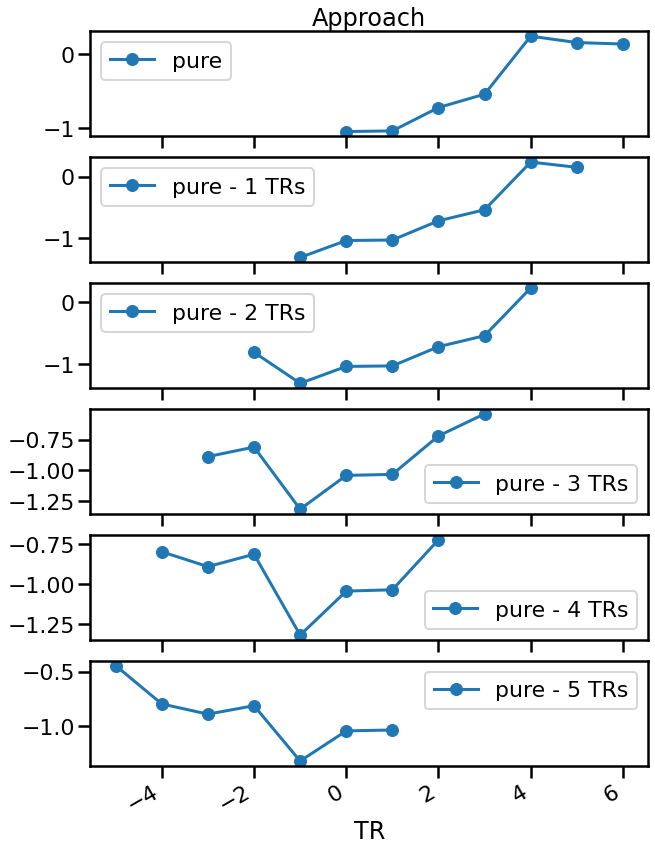

In [7]:
ax=pd.concat(approach,axis=1).plot(subplots=True,figsize=(10,15),color='C0',marker='o')
_=ax[0].set_title('Approach')
_=ax[-1].set_xlabel('TR')

Likewise, the single **retreat** ``training example 2`` mentioned above can be expanded into 6 segments.

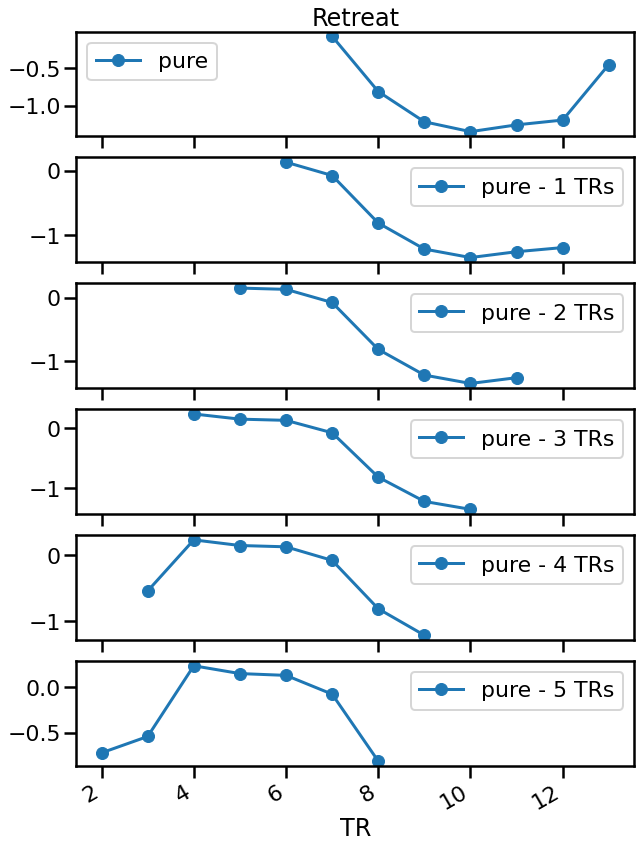

In [8]:
ax=pd.concat(retreat,axis=1).plot(subplots=True,figsize=(10,15),color='C0',marker='o')
_=ax[0].set_title('Retreat')
_=ax[-1].set_xlabel('TR')